In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting

import dame_flame
import random
np.random.seed(1) #ensure reproducibility


pd.options.mode.chained_assignment = None  #hide any pandas warnings

In [2]:
# Data on Ridership, where total_boardings is the number of boardings of a specific card_id on King County Metro.

In [3]:
clean_ridership_path = "/Users/JennyH/cisil-causal-inference/Data/flame_boardings.csv"
df_clean_ridership = pd.read_csv(clean_ridership_path)
df_clean_ridership = df_clean_ridership.iloc[:,1:]
df_clean_ridership

,RaceDesc,OverallJobAccess_D,lowwagelaborforce_D,Access30Transit_D,Access30Transit_ts_D,spatialmismatch_D,SAP,Agency,Language,stage,Age_bin,total_boardings
0,0,4,3,1,1,2,0,0,0,2,3,1.0
1,0,4,3,1,1,2,0,0,0,3,4,14.0
2,0,4,3,1,1,2,0,0,0,2,4,0.0
3,3,4,3,1,1,2,0,0,2,2,2,0.0
4,2,4,3,1,1,2,0,0,0,1,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
13543,1,2,2,1,1,3,0,1,0,1,3,0.0
13544,5,1,2,1,1,3,0,1,0,1,3,0.0
13545,0,1,2,1,1,3,0,1,0,1,0,0.0
13546,0,1,2,2,3,3,1,2,0,1,0,0.0


## Run FLAME for matching.

In [4]:
model_flame_AMT = dame_flame.matching.FLAME(repeats=False, 
                                            verbose=3, 
                                            early_stop_iterations=30, 
                                            stop_unmatched_t = True, 
                                            adaptive_weights='decisiontree', 
                                            want_pe=True)

In [5]:
model_flame_AMT.fit(holdout_data=False, 
                    treatment_column_name='SAP', 
                    outcome_column_name='total_boardings')

result_flame_AMT = model_flame_AMT.predict(df_clean_ridership)

Iteration number:  1
	Number of matched groups formed in total:  459
	Unmatched treated units:  3912 out of a total of  4973 treated units
	Unmatched control units:  7601 out of a total of  8575 control units
	Predictive error of covariates chosen this iteration:  0
	Number of matches made in this iteration:  2035
	Number of matches made so far:  2035
	In this iteration, the covariates dropped are:  set()
Iteration number:  2
	Number of matched groups formed in total:  527
	Unmatched treated units:  3809 out of a total of  4973 treated units
	Unmatched control units:  7523 out of a total of  8575 control units
	Predictive error of covariates chosen this iteration:  11767.285929916521
	Number of matches made in this iteration:  181
	Number of matches made so far:  2216
	In this iteration, the covariates dropped are:  Access30Transit_ts_D
Iteration number:  3
	Number of matched groups formed in total:  594
	Unmatched treated units:  3714 out of a total of  4973 treated units
	Unmatched c

<ipython-input-6-4a901d3a82e5>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels=x, rotation=90)


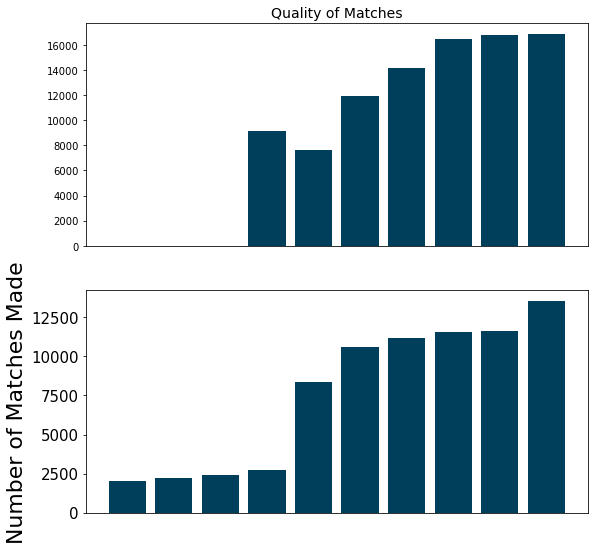

In [6]:
# Figure Visualzing Qualit of Matches (i.e. Match Group Size vs. Covariates Matched on.)
x = ["NONE", "Access30Transit_ts", '+Language', '+lowwagelaborforce', '+Agency', '+Age_bin', '+OverallJobAccess', '+Access30Transit', '+spatialmismatch', 'stage']
y1 = [0, 0, 0, 9130, 7614, 11950, 14126, 16455, 16815, 16854] # some of these will be repeat matches already made earlier iterations.
y2 = [2035, 2216, 2412, 2749, 8372, 10630, 11201, 11579, 11619, 13548]


f, ax = plt.subplots(ncols = 1, nrows = 2, gridspec_kw = {'width_ratios':[.51]}, figsize=(9,9))
# ax[0].set_ylabel('Number of Matches in Iteration', fontsize=14)
ax[0].set_xticklabels(labels=x, rotation=90)
ax[0].set_xlabel('Covariate(s) Dropped', fontsize=14)
ax[0].set_title('Quality of Matches', fontsize=14)
ax[0].bar(x,y1, color = '#003f5c')
ax[0].axes.xaxis.set_visible(False)

ax[1].set_ylabel('Number of Matches Made', fontsize=22)
ax[1].set_xlabel('Covariate(s) Dropped', fontsize=30)
# ax[1].set_title('Quality of Matches', fontsize=30)
ax[1].bar(x,y2, color = '#003f5c')
ax[1].tick_params(axis="y", labelsize=15)
ax[1].axes.xaxis.set_visible(False)


In [7]:
matched = model_flame_AMT.df_units_and_covars_matched
matched # covariates dropped according to predicting total_boardings

,RaceDesc,OverallJobAccess_D,lowwagelaborforce_D,Access30Transit_D,Access30Transit_ts_D,spatialmismatch_D,Agency,Language,stage,Age_bin
0,0,*,*,*,*,*,*,*,*,*
1,0,*,*,1,*,2,*,*,3,*
2,0,4,*,1,*,2,*,*,2,4
3,3,*,*,*,*,*,*,*,*,*
4,2,4,*,1,*,2,*,*,1,*
...,...,...,...,...,...,...,...,...,...,...
13543,1,*,*,*,*,3,*,*,1,*
13544,5,*,*,1,*,3,*,*,1,*
13545,0,1,*,1,*,3,*,*,1,0
13546,0,1,*,2,*,3,*,*,1,0


In [8]:
# ATE Estimate
ate_ridership = dame_flame.utils.post_processing.ATE(model_flame_AMT)
ate_ridership

40.700277677491634

## Create Scatterplots of Matched Groups.

In [9]:
def create_df_scatter(feature, category):
    '''
    Creates a scatter plot of the size of matched group against CATE estimate.
    
    feature (str): variable of interest.
    category (int): level of variable to highlight.
    '''
    group_size_overall = []
    cate_of_group = []
    in_desired_variable = []
    size_desired_group = []
    cate_desired_group = []
    

    for group in model_flame_AMT.units_per_group:

        # find len of just treated units
        df_mmg = df_clean_ridership.loc[group] # chooses rows with row id in group.
        treated = df_mmg.loc[df_mmg["SAP"] == 1] # chooses the rows with treatment = 1
        desired_variable = df_mmg.iloc[0][feature] == category # true/false vector. an indicator.

        # group_size_treated.append(len(treated))
        group_size_overall.append(len(group))
        in_desired_variable.append(desired_variable)
        
        

        cate_of_group.append(dame_flame.utils.post_processing.CATE(model_flame_AMT, group[0]))
        
        if desired_variable == True:
            cate_desired_group.append(dame_flame.utils.post_processing.CATE(model_flame_AMT, group[0]))
            size_desired_group.append(len(group))
        
    
    return(group_size_overall, cate_of_group, in_desired_variable, size_desired_group, cate_desired_group)

In [46]:
print(cate_all[:10])
print(size[:10])

[-186.0, -20.0, -19.133333333333333, 175.0, -31.4, 2.0, -5.0, -17.666666666666668, 3.0, 0.0]
[2, 3, 16, 2, 11, 2, 2, 4, 3, 2]


In [10]:
def create_cate_lst(sizes, cates):
    '''
    helper function to create credible interval for ATE. Creates an extended list
    where each element is the CATE for a unit.'''
    
    out = []
    for i in range(len(cates)):
        for j in range(sizes[i]):
            out.append(cates[i])
    return out   

In [12]:
s_test = [1,3,5,10]
c_test = [-1,0,4,20]

In [ ]:
# Calculate the quantiles for ATE.
cate_test = create_cate_lst(s_test, c_test)
print(cate_test)

In [21]:
# Calculate the quantiles for ATE.
(size, cate_all, in_asian, size_asian, cate_asian) = create_df_scatter("RaceDesc", 2)

cate_lst = create_cate_lst(size, cate_all)

In [24]:
q025 = np.percentile(cate_lst, 2.5) # return 50th percentile, e.g median.
q975 = np.percentile(cate_lst, 97.5)
print (q025, q975)

# normal approximation
lb = ate_ridership - 1.96*(np.std(cate_lst) / np.sqrt(len(cate_lst)))
ub = ate_ridership + 1.96*(np.std(cate_lst) / np.sqrt(len(cate_lst)))
print(lb, ub)     

-142.1625 351.33333333333337
38.39968304486277 43.0008723101205


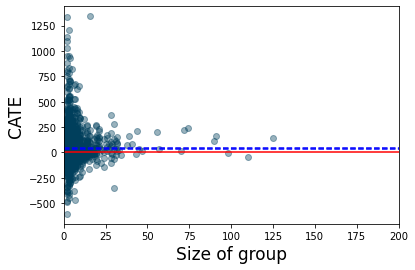

In [27]:
# Scatter Plot for CATE
cors = {True:"green", False:"green"}
 #hisp = pd.Series(in_hisp)

plt.scatter(size, cate_all, c = "#003f5c", alpha=0.4)
plt.axhline(y=0.0, color='r', linestyle='-')
plt.axhline(y=lb, color='blue', linestyle='--')
plt.axhline(y=ub, color='blue', linestyle='--')
plt.xlim(0,200)
plt.xlabel('Size of group', fontsize=12)
plt.ylabel('Estimated Treatment Effect of Group', fontsize=12)
# plt.title("Visualizing Enrollment CATE of matched groups by size", fontsize=14)

plt.xlabel('Size of group', fontsize=17)
plt.ylabel('CATE', fontsize=17)

# plt.savefig('ate_scatter.pdf', bbox_inches="tight")

In [28]:
# race = {"White": 0, "Black or African American": 1, "Asian": 2, "Hispanic or Latino": 3, "Not Specified": 4, 'Other': 5, 'American Indian or Alaska Native': 6, "Multi-Racial": 7, "Native Hawaiian or Other Pacific Islander": 8}
(size, cate_all, in_asian, size_asian, cate_asian) = create_df_scatter("RaceDesc", 2)


In [29]:
## Conf. Interval for Asian CATE estimates
cate_lst = create_cate_lst(size_asian, cate_asian)
mean_cate_asian = sum(cate_lst)/len(cate_lst)
mean_cate_asian

95.57901552178491

In [30]:
## Conf. Interval for Asian CATE estimates

# normal approximation
lb = mean_cate_asian - 1.96*(np.std(cate_lst) / np.sqrt(len(cate_lst)))
ub = mean_cate_asian + 1.96*(np.std(cate_lst) / np.sqrt(len(cate_lst)))
print(lb, ub)  

88.75113088839974 102.40690015517008


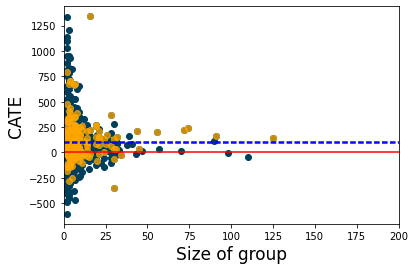

In [32]:
# Scatter Plot displaying the CATEs for matched groups with Asian individuals

cors = {True:'#bc5090', False:'#ffa600'}
asian = pd.Series(in_asian)

plt.scatter(size, cate_all, c = "#003f5c", alpha=1)
plt.scatter(size_asian, cate_asian, c = "#ffa600", alpha=.75)

plt.axhline(y=0.0, color='r', linestyle='-')
plt.axhline(y=lb, color='blue', linestyle='--')
plt.axhline(y=ub, color='blue', linestyle='--')
plt.xlim(0,200)
plt.xlabel('Size of group', fontsize=17)
plt.ylabel('CATE', fontsize=17)

# plt.savefig('asian.pdf', bbox_inches="tight")

In [33]:
# race = {"White": 0, "Black or African American": 1, "Asian": 2, "Hispanic or Latino": 3, "Not Specified": 4, 'Other': 5, 'American Indian or Alaska Native': 6, "Multi-Racial": 7, "Native Hawaiian or Other Pacific Islander": 8}
# Hispanic
(size, cate_all, in_hisp, size_hispanic, cate_hispanic) = create_df_scatter("RaceDesc", 3)


In [34]:
## Conf. Interval
cate_hispanic_lst = create_cate_lst(size_hispanic, cate_hispanic)
mean_cate_h = sum(cate_hispanic_lst)/len(cate_hispanic_lst)
mean_cate_h

-56.60015433859185

In [35]:
# normal approximation
lb = mean_cate_h - 1.96*(np.std(cate_hispanic_lst) / np.sqrt(len(cate_hispanic_lst)))
ub = mean_cate_h + 1.96*(np.std(cate_hispanic_lst) / np.sqrt(len(cate_hispanic_lst)))
print(lb, ub)  

-62.201484513907964 -50.998824163275735


In [103]:
matplotlib.rcParams.update({'font.size': 14})

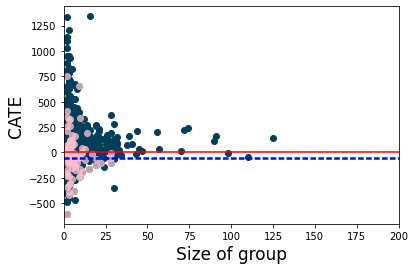

In [36]:
# Scatter plot Hispanic Individuals.

plt.scatter(size, cate_all, c = "#003f5c", alpha=1)
plt.scatter(size_hispanic, cate_hispanic, c = "pink", alpha=.75)

plt.axhline(y=0.0, color='r', linestyle='-')
plt.axhline(y=lb, color='blue', linestyle='--')
plt.axhline(y=ub, color='blue', linestyle='--')
plt.xlim(0,200)
plt.xlabel('Size of group', fontsize=17)
plt.ylabel('CATE', fontsize=17)

# plt.savefig('hispanic.pdf', bbox_inches="tight")

In [94]:
(size, cate_all, in_access_one, size_access_one, cate_access_one) = create_df_scatter("Access30Transit_D", 1)

In [76]:
## Conf. Interval
cate_acc_lst = create_cate_lst(size_access_one, cate_access_one)

q025 = np.percentile(cate_acc_lst, 2.5)
q975 = np.percentile(cate_acc_lst, 97.5)
print (q025, q975)

-85.175 189.33333333333334


Text(0.5, 1.0, 'Access to Transit in Bottom 25%')

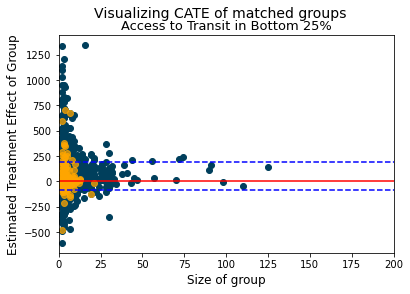

In [78]:
# Scatter plot ("Access30Transit_D", 1) people with Bottom 25% access to transit.

# plot
plt.scatter(size, cate_all, c = "#003f5c", alpha=1)
plt.scatter(size_access_one, cate_access_one, c = "#ffa600", alpha=.75)

plt.axhline(y=0.0, color='r', linestyle='-')
plt.axhline(y=q025, color='blue', linestyle='--')
plt.axhline(y=q975, color='blue', linestyle='--')
plt.xlim(0,200)

plt.xlabel('Size of group', fontsize=12)
plt.ylabel('Estimated Treatment Effect of Group', fontsize=12)
plt.suptitle("Visualizing CATE of matched groups", fontsize=14)
plt.title("Access to Transit in Bottom 25%", fontsize=13)

In [79]:
(size, cate_all, in_access_four, size_access_four, cate_access_four) = create_df_scatter("Access30Transit_D", 4)

In [80]:
## Conf. Interval
cate_acc_lst = create_cate_lst(size_access_four, cate_access_four)

q025 = np.percentile(cate_acc_lst, 2.5)
q975 = np.percentile(cate_acc_lst, 97.5)
print (q025, q975)

-165.07142857142858 371.6923076923077


Text(0.5, 1.0, 'Access to Transit in Top 25%')

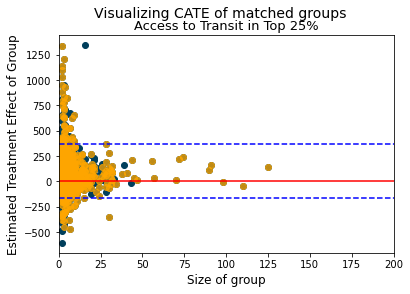

In [82]:
# People in the Top 25% access to transit.

# plot
plt.scatter(size, cate_all, c = "#003f5c", alpha=1)
plt.scatter(size_access_four, cate_access_four, c = "#ffa600", alpha=.75)

plt.axhline(y=0.0, color='r', linestyle='-')
plt.axhline(y=q025, color='blue', linestyle='--')
plt.axhline(y=q975, color='blue', linestyle='--')
plt.xlim(0,200)

plt.xlabel('Size of group', fontsize=12)
plt.ylabel('Estimated Treatment Effect of Group', fontsize=12)
plt.suptitle("Visualizing CATE of matched groups", fontsize=14)
plt.title("Access to Transit in Top 25%", fontsize=13)

In [ ]:
# Overall job access.

## Compute Confidence Intervals for CATE

In [46]:
# Based on Vittorio's Code: https://github.com/vittorioorlandi/FLAME/blob/master/R/post_matching.R#L236

# problem is CATE for asian individuals involves avging the CATE of all matched groups containing Asian individuals.

#    CATE_mat[as.character(unit), 'Mean'] <- mean(Y[treated]) - mean(Y[control])
#    CATE_mat[as.character(unit), 'Variance'] <-
#      var(Y[treated]) / length(treated) +
#      var(Y[control]) / length(control)
#  }

In [6]:
def var_test(data):
    # Number of observations
    n = len(data)
    # Mean of the data
    mean = sum(data) / n
    # Square deviations
    deviations = [(x - mean) ** 2 for x in data]
    # Variance
    variance = sum(deviations) / n
    # print(variance)
    
    return variance

In [11]:
def CATE_variance(matching_object, unit_ids, mice_iter=0):
    '''
    This function returns the CATEs for all specified unit indices
    Args:
        matching_object (DAME or FLAME object)
        unit_ids (int, list): units for which MG will be returned
    Returns:
        CATEs: list of floats or singular float containing the CATEs
            of the main matched groups for the specified units
    '''

    # Accept int or list for unit_id
    if type(unit_ids) is int:
        unit_ids = [unit_ids]

    # validate_matching_obj(matching_object)


    if (matching_object.missing_data_replace != 3):
        arr_matched_groups = matching_object.units_per_group        
        df_matched_units = matching_object.df_units_and_covars_matched
    else:
        arr_matched_groups = matching_object.units_per_group[mice_iter]
        df_matched_units = matching_object.df_units_and_covars_matched[mice_iter]

    # Recover CATEs
    cates = []
    variance = []
    num_treated_units = []
    for unit in unit_ids:
        if unit in df_matched_units.index:
            for group in arr_matched_groups:
                # The first group to contain the specified unit is the MMG
                if unit in group:
                    df_mmg = matching_object.input_data.loc[group, 
                        [matching_object.treatment_column_name,
                         matching_object.outcome_column_name]]
                    break
            # Assuming an MMG has been found, compute CATE for that group
            treated = df_mmg.loc[df_mmg[matching_object.treatment_column_name] == 1]
            control = df_mmg.loc[df_mmg[matching_object.treatment_column_name] == 0]
            # treated[matching_object.outcome_column_name] - Y[treated]
            # treated.index - all treated individuals.
            avg_treated = sum(treated[matching_object.outcome_column_name])/len(treated.index)
            avg_control = sum(control[matching_object.outcome_column_name])/len(control.index)
            
            if len(treated[matching_object.outcome_column_name]) > 1:
                var_treated = var_test(treated[matching_object.outcome_column_name]) / len(treated.index) # why did they divide by n? https://github.com/vittorioorlandi/FLAME/blob/master/R/post_matching.R#L236
                var_control = var_test(control[matching_object.outcome_column_name]) / len(control.index)
                variance.append(var_treated + var_control)
            else:
                variance.append(0) # no valid variance can be calculated for matched groups composed of 1 treatment and 1 control unit.
            
            
            num_treated_units.append(len(treated.index))
            cates.append(avg_treated - avg_control)
            
            
            
        # Warn user that unit has no matches
        else:
            cates.append(np.nan)
            if matching_object.verbose != 0:
                print('Unit ' + str(unit) + " does not have any matches, so " \
                      "can't find the CATE")

    # Format output
    if len(cates) == 1:
        cates = cates[0]
        variance = variance[0]
        num_treated_units = num_treated_units[0]
        
    return cates, variance, num_treated_units


In [15]:
cate_test = CATE_variance(model_flame_AMT, 5)
cate_test

(639.5, 14028.125, 2)

In [ ]:
def ATE_variance(matching_object, mice_iter=0):
    '''
    This function returns the ATE for the matching data
    Args:
        matching_object (DAME or FLAME object)
    Returns:
        ATE: the average treatment effect for the matching data
    '''

    validate_matching_obj(matching_object)

    if matching_object.missing_data_replace != 3:
        arr_matched_groups = matching_object.units_per_group
        num_groups_per_unit = matching_object.groups_per_unit
    else:
        arr_matched_groups = matching_object.units_per_group[mice_iter]
        num_groups_per_unit = matching_object.groups_per_unit[mice_iter]

    # Recover CATEs
    cates = [0] * len(arr_matched_groups) # this will be a CATE for each matched group
    for group_id in range(len(arr_matched_groups)):
        group_data = matching_object.input_data.loc[arr_matched_groups[group_id],
                                                    [matching_object.treatment_column_name,
                                                     matching_object.outcome_column_name]]
        treated = group_data.loc[group_data[matching_object.treatment_column_name] == 1]
        control = group_data.loc[group_data[matching_object.treatment_column_name] == 0]
        try:
            avg_treated = sum(treated[matching_object.outcome_column_name]) / len(treated.index)
            avg_control = sum(control[matching_object.outcome_column_name]) / len(control.index)
        except:
            print("There was an error in the matching process.", group_id)
            break
        cates[group_id] = avg_treated - avg_control

    # Compute ATE
    weight_sum = 0
    weighted_cate_sum = 0
    for group_id in range(len(arr_matched_groups)):
        matched_group_weight = 0
        for unit in arr_matched_groups[group_id]:
            matched_group_weight += num_groups_per_unit[unit]
        weight_sum += matched_group_weight
        weighted_cate_sum += matched_group_weight * cates[group_id]

    return weighted_cate_sum/weight_sum

In [16]:
def conf_interval_CATE(cate_test, Z):
    return [cate_test[0] - Z*np.sqrt(cate_test[1])/np.sqrt(cate_test[2]), 
            cate_test[0] + Z*np.sqrt(cate_test[1])/np.sqrt(cate_test[2])]
            

In [17]:
conf_interval_CATE(cate_test, 1.96)

[475.35, 803.65]

## Compute CATE Values

In [9]:
def compute_cates(column_name: str) -> dict:
    """
    Return dictionary where
    - the dictionary keys are a value in a column (i.e. Asian) and 
    - the dictionary value are the CATEs for all the units that have that value in the column (i.e. race=Asian) 
    """
    cates = {}
    cates_avg = {}
    for val in set(matched[column_name].tolist()):
        cates[val] = []
        print(f'Calculating cates for column: {column_name}, for value: {val}')
        for i in matched[(matched[column_name] == val)].index:
            cates[val].append(dame_flame.utils.post_processing.CATE(model_flame_AMT, i))
        cates_avg[val] = sum(cates[val]) / len(cates[val])
    return cates_avg

def get_cates_and_counts(column_name: str) -> pd.DataFrame:
    """
    Return pd DataFrame with CATE values and Count Values to plot both
    
    - 'CATE' column has CATE value corresponding to all the units with that value in the column
    - 'Counts' column has the number of all units in the data that are matched to a group that 
    has that specific value, i.e. 1791 individuals/units with matched in a group such that race=White
    """
    cates_avg = compute_cates(column_name)
    cates_avg_series = pd.Series(cates_avg)
    
    num_lvls = matched[column_name].value_counts()
    frame = {'CATE': cates_avg_series, 
             'Counts': num_lvls}
    data = pd.DataFrame(frame)
    data.index = data.index.map(str)
    data = data.sort_index() 
    return data

# non-response columns: 
cols = ['RaceDesc', 'OverallJobAccess_D', 'lowwagelaborforce_D', 'Access30Transit_D', 'Access30Transit_ts_D', 'spatialmismatch_D', 'Agency', 'Language', 'stage', 'Age_bin']

df_dic = {}

def export_cate_df(cols: list): 
    """
    Create dictionary where
    - keys are column (i.e. White)
    - values are pandas dataframe (i.e. pandas dataframe created using get_cates_and_counts() that shows CATE
    values and counts)
    """
    for col in cols:
        df_dic[col] = get_cates_and_counts(col)

export_cate_df(cols)


Calculating cates for column: RaceDesc, for value: 0.0
Calculating cates for column: RaceDesc, for value: 1.0
Calculating cates for column: RaceDesc, for value: 2.0
Calculating cates for column: RaceDesc, for value: 3.0
Calculating cates for column: RaceDesc, for value: 4.0
Calculating cates for column: RaceDesc, for value: 5.0
Calculating cates for column: RaceDesc, for value: 6.0
Calculating cates for column: RaceDesc, for value: 7.0
Calculating cates for column: RaceDesc, for value: 8.0
Calculating cates for column: OverallJobAccess_D, for value: 1.0
Calculating cates for column: OverallJobAccess_D, for value: 2.0
Calculating cates for column: OverallJobAccess_D, for value: 3.0
Calculating cates for column: OverallJobAccess_D, for value: *
Calculating cates for column: OverallJobAccess_D, for value: 4.0
Calculating cates for column: lowwagelaborforce_D, for value: 1.0
Calculating cates for column: lowwagelaborforce_D, for value: 2.0
Calculating cates for column: lowwagelaborforce_D,

KeyboardInterrupt: 

In [147]:
artifacts_filepath = '/Users/albertsun/Projects/artifacts/'
response_var = 'ridership'

import seaborn as sns
sns.set_theme(style="white")
sns.set(font_scale=2)

In [142]:
plt.rcParams["figure.figsize"] = (8,11)

In [148]:
def plot_column_CATE(column, title=None, xaxistitle=None, rename_dic=None) -> None:
    """
    Generalized function that plots the CATE and counts for everything in a particular column, i.e. 
    "race". Must run previous helper functions for this to work. 
    
    Takes:
    - column - column name
    - title - plot title
    - xaxistitle - x axis title 
    
    Returns:
    - None
    
    """
    
    if title ==None: 
        title = column + " CATE on Ridership"
        
    df = df_dic[column]
    
    df = df.rename(index={'*': 'Unmatched'})
    
    if rename_dic != None: 
        df = df.rename(index=rename_dic)
    
    df = df.sort_values('CATE', ascending=False)
    df.plot.bar(rot=0, subplots=True, fontsize = 20)
    sns.set_theme(style="white")
    
    plt.xlabel(xaxistitle)
    
    #plt.subplots_adjust(top=0.85)
    #plt.gcf().subplots_adjust(bottom=0.20)

    plt.suptitle(title, fontweight='bold')
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
    plt.savefig(artifacts_filepath + 'Ridership_CATE_' + response_var + '_' + column + '.png')
    

    return df

In [149]:
dic_race_rename = {'0.0': 'White',
            '1.0': 'Black',
            '2.0': 'Asian',
            '3.0': 'Hispanic',
            '4.0': 'Not Specified',
            '5.0': 'Other',
            '6.0': 'American Indian',
            '7.0': 'Multi-Racial',
            '8.0': 'Pacific Islander',
            '*': 'Umatched'}

dic_language_rename = {"0.0":"English", 
                       "1.0":"Chinese", 
                       "2.0":"Spanish", 
                       "3.0":"Dari", 
                       "4.0":"Vietnamese", 
                       "5.0":'Other'}

dic_agency_rename = {"0.0":"King County Public Health", 
     "1.0":"DSHS - ORCA LIFT (remote enrollment)", 
     "2.0":"DSHS - subsidized annual pass (remote enrollment)", 
     "3.0":"CCS", 
     "4.0":"KCMCCS", 
     "5.0":'Other'}



,CATE,Counts
Asian,95.579016,2433
Other,53.419218,673
Black,44.248860,2795
Pacific Islander,43.268852,195
Not Specified,41.903843,1062
White,40.693089,4253
American Indian,29.795194,417
Multi-Racial,24.100184,225
Hispanic,-56.600154,1495


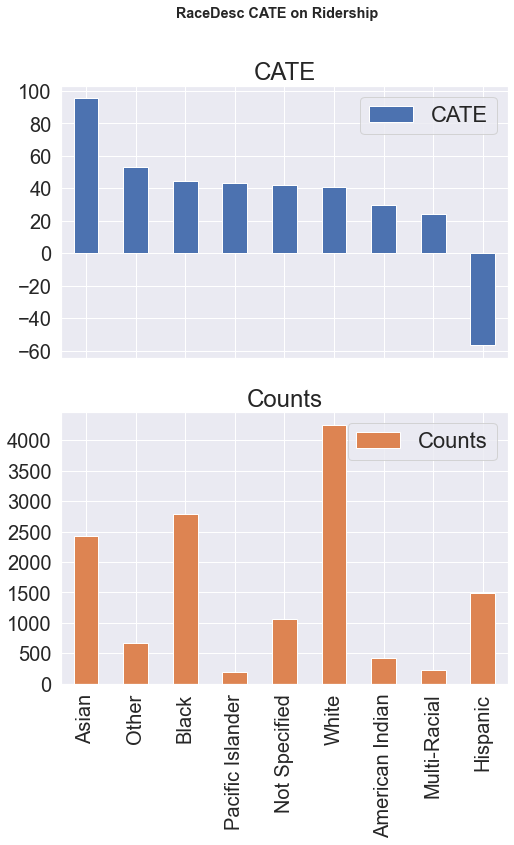

In [150]:
plot_column_CATE(column='RaceDesc', rename_dic=dic_race_rename)

,CATE,Counts
4.0,60.664717,6166
3.0,47.840661,2809
2.0,38.455006,1235
1.0,22.637398,991
Unmatched,-11.487556,2347


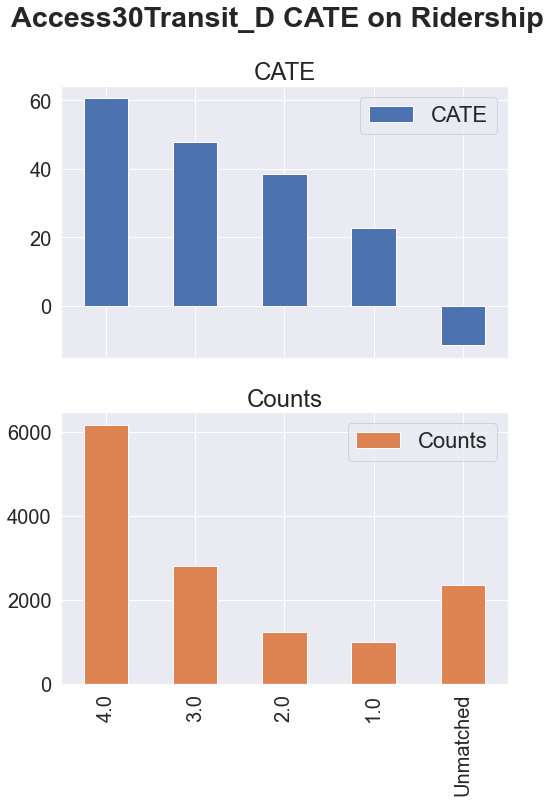

In [146]:
plot_column_CATE(column='Access30Transit_D')

,CATE,Counts
4.0,57.638961,6128
3.0,48.202527,2201
1.0,45.479964,735
2.0,39.713062,1566
Unmatched,-1.205065,2918


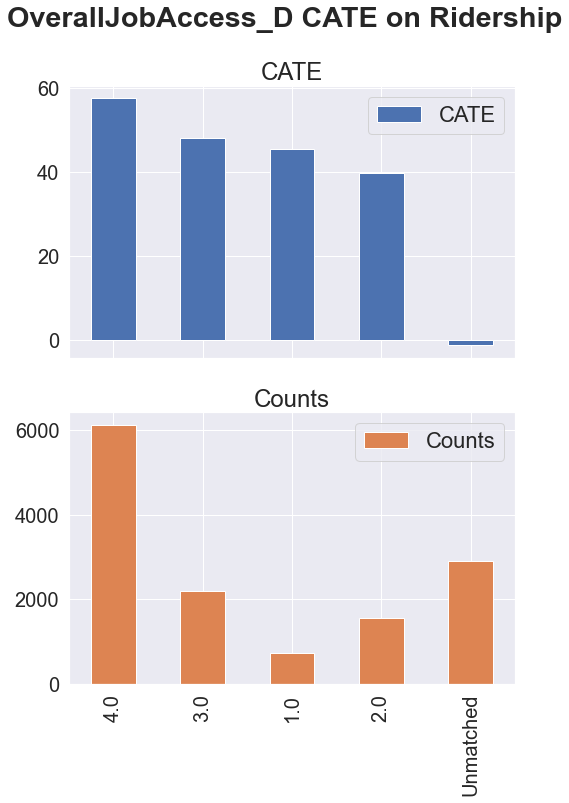

In [132]:
plot_column_CATE(column='OverallJobAccess_D')

,CATE,Counts
DSHS - subsidized annual pass (remote enrollment),124.109910,37
CCS,92.197353,318
King County Public Health,47.937022,2248
Unmatched,38.017192,10799
DSHS - ORCA LIFT (remote enrollment),13.880952,54
Other,0.000000,2
KCMCCS,-17.367963,90


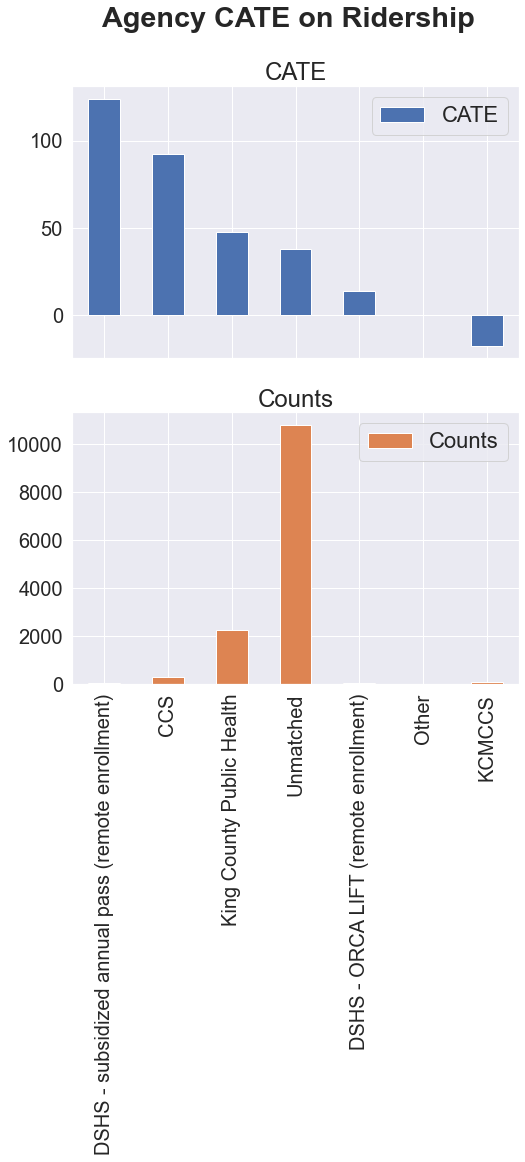

In [133]:
plot_column_CATE(column='Agency', rename_dic=dic_agency_rename)

,CATE,Counts
Spanish,126.384615,13
Vietnamese,87.117188,16
Chinese,87.030417,373
English,41.631715,1784
Unmatched,38.930074,11332
Other,16.052222,30


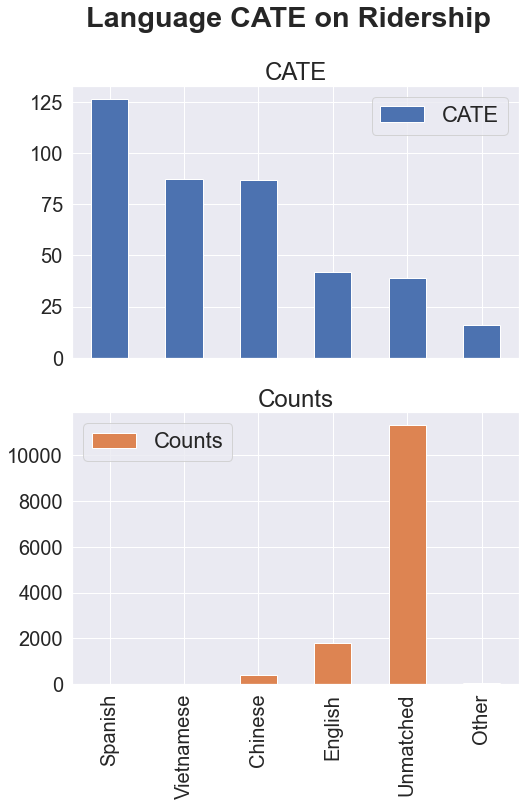

In [134]:
plot_column_CATE(column='Language', rename_dic=dic_language_rename)



,CATE,Counts
5.0,271.250000,8
4.0,106.023822,117
1.0,57.254184,7298
3.0,48.548661,846
2.0,38.816479,3350
Unmatched,-27.017020,1929


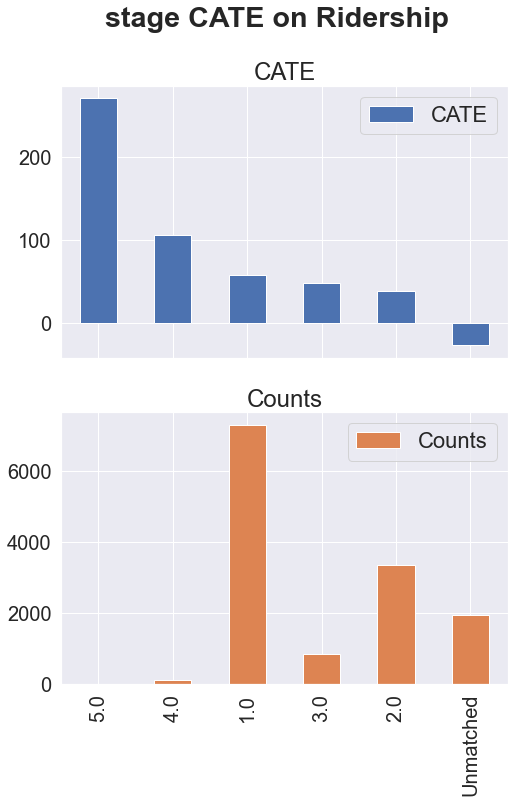

In [135]:
plot_column_CATE(column='stage')



,CATE,Counts
5.0,131.497466,1313
4.0,52.268758,1448
3.0,43.349692,1598
Unmatched,29.571994,5176
2.0,26.685392,1512
1.0,22.884935,1617
0.0,3.818244,884


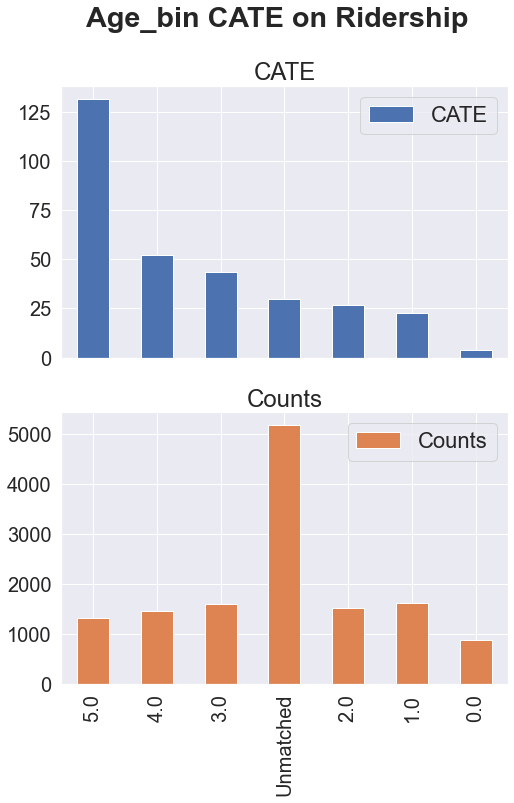

In [136]:
plot_column_CATE(column='Age_bin')

,CATE,Counts
4.0,59.254674,1747
Unmatched,38.743173,11513
3.0,16.045778,225
2.0,-9.625000,28
1.0,-42.900000,35


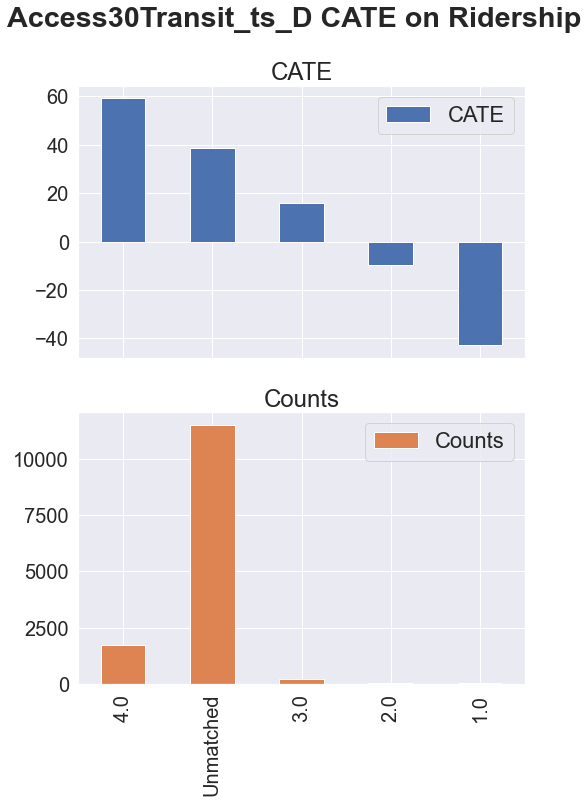

In [137]:
plot_column_CATE(column='Access30Transit_ts_D')



,CATE,Counts
2.0,63.297941,2981
3.0,60.381164,3084
1.0,44.133325,2624
4.0,38.473029,2890
Unmatched,-25.643580,1969


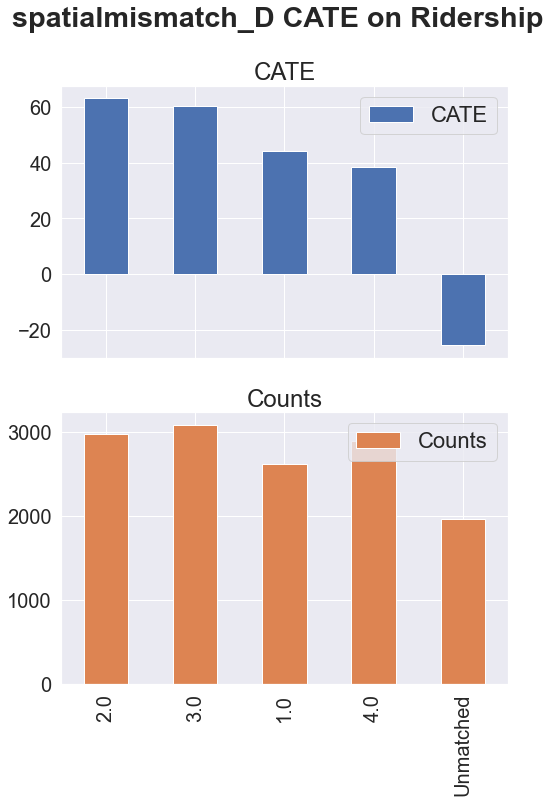

In [138]:
plot_column_CATE(column='spatialmismatch_D')

